In [3]:
import GPI_init_fit as gpi
import numpy as np
import matplotlib.pyplot as plt
import optimization.interpolated_univariate_spline as spline_func
from astropy.stats import bayesian_info_criterion as bic
from astropy.stats import akaike_info_criterion as aic

## Initial Fit With Scipy Minimize 

### Model with 9 knots is preferred

In [5]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"
from astropy.io import fits
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.3'
jax.config.update("jax_enable_x64", True)
import pandas as pd
from optimization.optimize_framework import Optimizer, OptimizeUtils
from disk_model.objective_functions import objective_model, objective_ll, objective_fit, Parameter_Index
from disk_model.SLD_ojax import ScatteredLightDisk
from disk_model.SLD_utils import *

In [30]:
name = 'hr4796a_H_pol'
fits_image_filepath = "/home/blewis/GPI_data/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)

In [31]:
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:],bounds=(50, 230, 50, 230))
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:]),bounds=(50, 230, 50, 230))
misc_params = Parameter_Index.misc_params
misc_params['nx'] = 180
misc_params['ny'] = 180 #, outlier_pixels=[(57, 68)]))

In [ ]:
num_knots = 9

spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = EMP_PSF.params
disk_params = Parameter_Index.disk_params

image_data = pd.read_csv('statistical_analysis/image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "a_in", "a_out", "eccentricity", "ksi0", "gamma", "beta", "omega", "x_center", "y_center", "knots"]
row = image_data.loc[name]

disk_params['sma'] = row["Radius"]
disk_params['inclination'] = row["Inclination"]
disk_params['position_angle'] = row["Position Angle"]
misc_params['distance'] = row["Distance"]
spf_params['num_knots'] = num_knots
spf_params['knot_values'] = jnp.full(spf_params['num_knots'],0.5)
disk_params['alpha_in'] = row['a_in']
disk_params['alpha_out'] = row['a_out']
disk_params['e'] = row['eccentricity']
disk_params['ksi0'] = row['ksi0']
disk_params['gamma'] = row['gamma']
disk_params['beta'] = row['beta']
disk_params['omega'] = row['omega']
disk_params['x_center'] = row['x_center']
disk_params['y_center'] = row['y_center']

In [12]:
opt = Optimizer(disk_params, spf_params, psf_params, misc_params, 
                ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0','gamma','beta','omega','inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling','knot_values']
opt.inc_bound_knots()
opt.scale_initial_knots(target_image)
soln = opt.scipy_optimize(fit_keys, target_image, err_map, disp_soln=True,iters = 1000)
opt.scale_spline_to_fixed_point(0, 1)
optimal_image = opt.model()
optimal_ll = opt.log_likelihood(target_image,err_map)

2025-05-19 10:58:04.806813: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng28{k2=1,k3=0} for conv %cudnn-conv = (f64[1,1,180,180]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,319,319]{3,2,1,0} %bitcast.91795, f64[1,1,140,140]{3,2,1,0} %bitcast.91796), window={size=140x140}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_name="jit(jax_model_spline)/jit(main)/jit(generate)/conv_general_dilated" source_file="/home/blewis/GRaTeR-JAX/disk_model/SLD_utils.py" source_line=474}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-19 10:58:04.823106: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.016420068s
Trying algorithm eng28{k2=1,k3=0} for conv %cudnn-conv = (f64[1,1,180,180]{3,2,1,0}, u8[0]{0}) custom-cal

         Current function value: 79173.111107
         Iterations: 92
         Function evaluations: 4425
         Gradient evaluations: 192
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 79173.11110664587
        x: [ 4.467e+01 -1.899e+01 ...  2.661e+00 -5.757e+00]
      nit: 92
      jac: [ 1.441e+00 -4.340e+00 ... -7.607e-01  5.859e-03]
 hess_inv: [[ 1.039e-01  1.379e-01 ... -1.597e-03  8.211e-03]
            [ 1.379e-01  1.998e-01 ... -3.305e-03  1.176e-02]
            ...
            [-1.597e-03 -3.305e-03 ...  1.962e-03 -2.485e-03]
            [ 8.211e-03  1.176e-02 ... -2.485e-03  5.334e-02]]
     nfev: 4425
     njev: 192


In [13]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 44.66908855311905, 'alpha_out': -18.994041396156348, 'sma': 76.30732514588723, 'e': 0, 'ksi0': 0.08464269122686588, 'gamma': 0.35753323852943064, 'beta': 8.690123680229297, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 76.58573449293846, 'position_angle': 26.599618929381958, 'x_center': 91.58790672143512, 'y_center': 90.51256136543492, 'halfNbSlices': 25, 'omega': 0.0}
SPF Params: {'low_bound': Array(-0.97236992, dtype=float64), 'up_bound': Array(0.97236992, dtype=float64), 'num_knots': 9, 'knot_values': Array([4.12106645e+00, 1.97073836e+00, 1.65738038e+00, 1.12874343e+00,
       1.00000000e+00, 6.34393189e-01, 5.01409408e-01, 2.40206075e-01,
       5.30503114e-05], dtype=float64)}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 180, 'ny': 180, 'halfNbSlices': 25, 'flux_scaling': Array(192043.51612625, dtype=float64)}


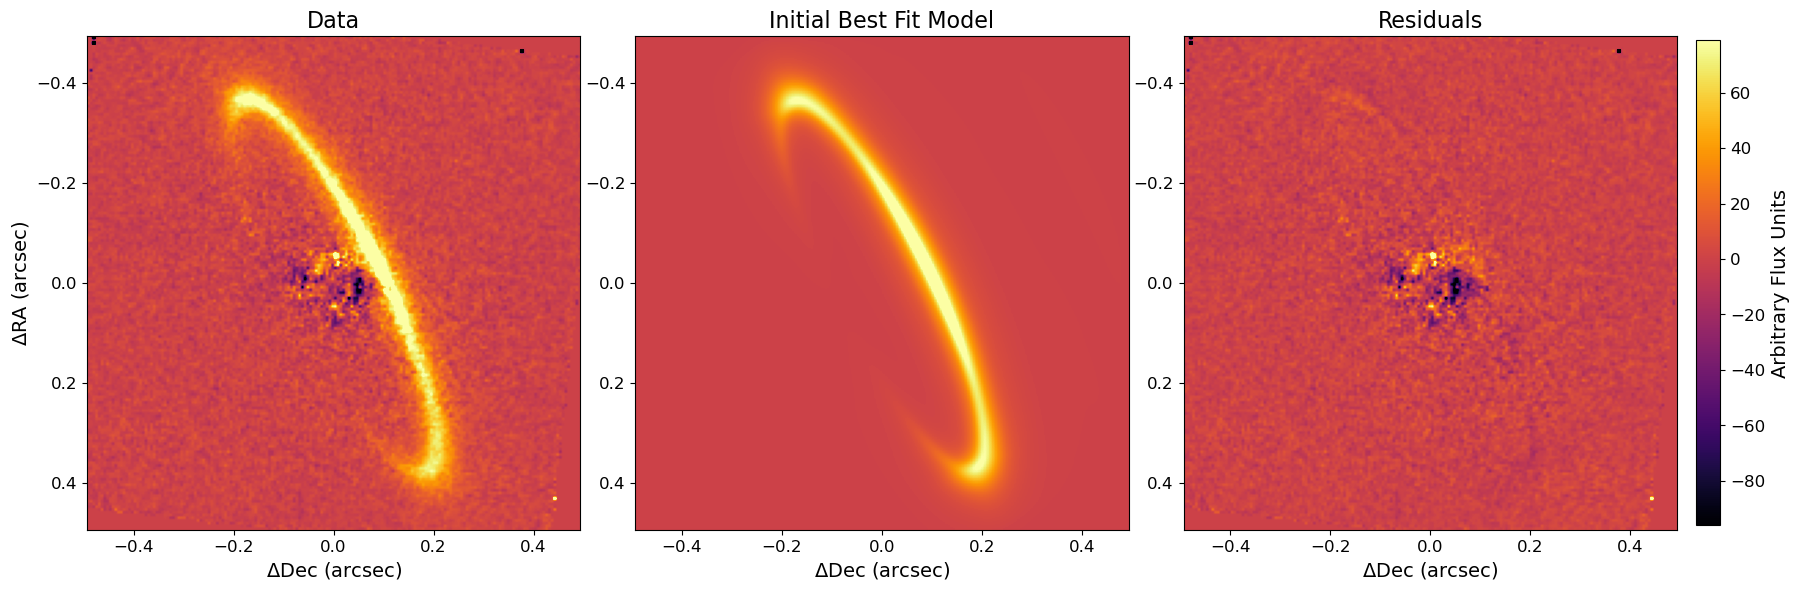

In [14]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("Initial Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=10)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_init_fit.png'.format(name))

166.5 13.50000000000001
[4.12106645e+00 1.97073836e+00 1.65738038e+00 1.12874343e+00
 1.00000000e+00 6.34393189e-01 5.01409408e-01 2.40206075e-01
 5.30503114e-05]


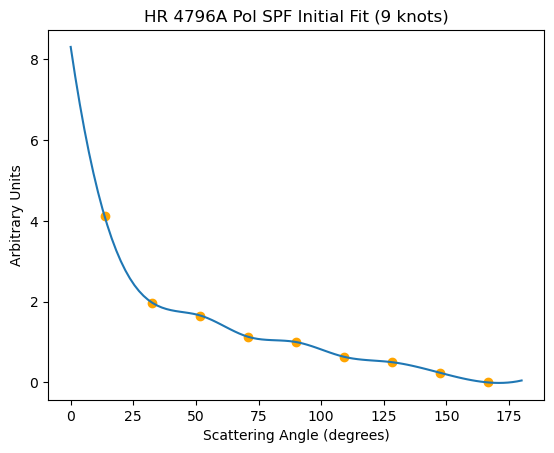

In [15]:
spf1 = opt.spf_params

hi = np.rad2deg(np.arccos(spf1['low_bound']))
lo = np.rad2deg(np.arccos(spf1['up_bound']))
print(hi,lo)

print(spf1['knot_values'])
spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,num_knots),spf1['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func)
plt.scatter(np.linspace(lo,hi,num_knots),spf1['knot_values'],color='orange')

###CHANGE NAMES
plt.title('HR 4796A Pol SPF Initial Fit (9 knots)')
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.savefig('../GPI_results/best_fits/hr4796a_pol_spf_init.png',bbox_inches='tight')

## MCMC Fit

In [16]:
bounds = ([0.1, -45, 0, 0,0.01,0.1,0.1,-20, 0, -20, 80, 80, 0, np.zeros(num_knots)],
          [45, -0.1, 150,1,0.35,0.6,15,380, 180, 380, 100, 100, 5e5, 1e4*np.ones(num_knots)])

opt.disk_params['e'] = 1e-5
opt.disk_params['omega'] = 1e-5
opt.disk_params['sma'] = 73

mc_model = opt.mcmc(fit_keys, target_image, err_map, bounds, nwalkers=100, niter=150, burns=20)

Running burn-in...


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Running production...


100%|██████████| 150/150 [02:36<00:00,  1.04s/it]


In [17]:
mc_soln = np.median(mc_model.sampler.flatchain, axis=0)
img = opt.model()

In [18]:
opt.print_params()

Disk Params: {'accuracy': 0.005, 'alpha_in': 44.03993428769426, 'alpha_out': -18.780358309817682, 'sma': 72.66790383268534, 'e': 0.2010573859843548, 'ksi0': 0.1566182179632305, 'gamma': 0.2197681558275302, 'beta': 8.232534179162046, 'rmin': 0.0, 'dens_at_r0': 1.0, 'inclination': 76.13813323654236, 'position_angle': 26.60338318072506, 'x_center': 91.21057239457747, 'y_center': 90.5146897884181, 'halfNbSlices': 25, 'omega': -0.4754155052264219}
SPF Params: {'low_bound': Array(-0.97236992, dtype=float64), 'up_bound': Array(0.97236992, dtype=float64), 'num_knots': 9, 'knot_values': array([5.72153167e+00, 9.56326923e-01, 9.79184312e-01, 1.12874795e+00,
       1.91175460e+00, 9.51000706e-01, 2.81878604e-01, 1.59258586e-01,
       5.28733640e-05])}
PSF Params: {'scale_factor': 1, 'offset': 1}
Misc Params: {'distance': 72.78, 'pxInArcsec': 0.01414, 'nx': 180, 'ny': 180, 'halfNbSlices': 25, 'flux_scaling': 192043.17676110766}


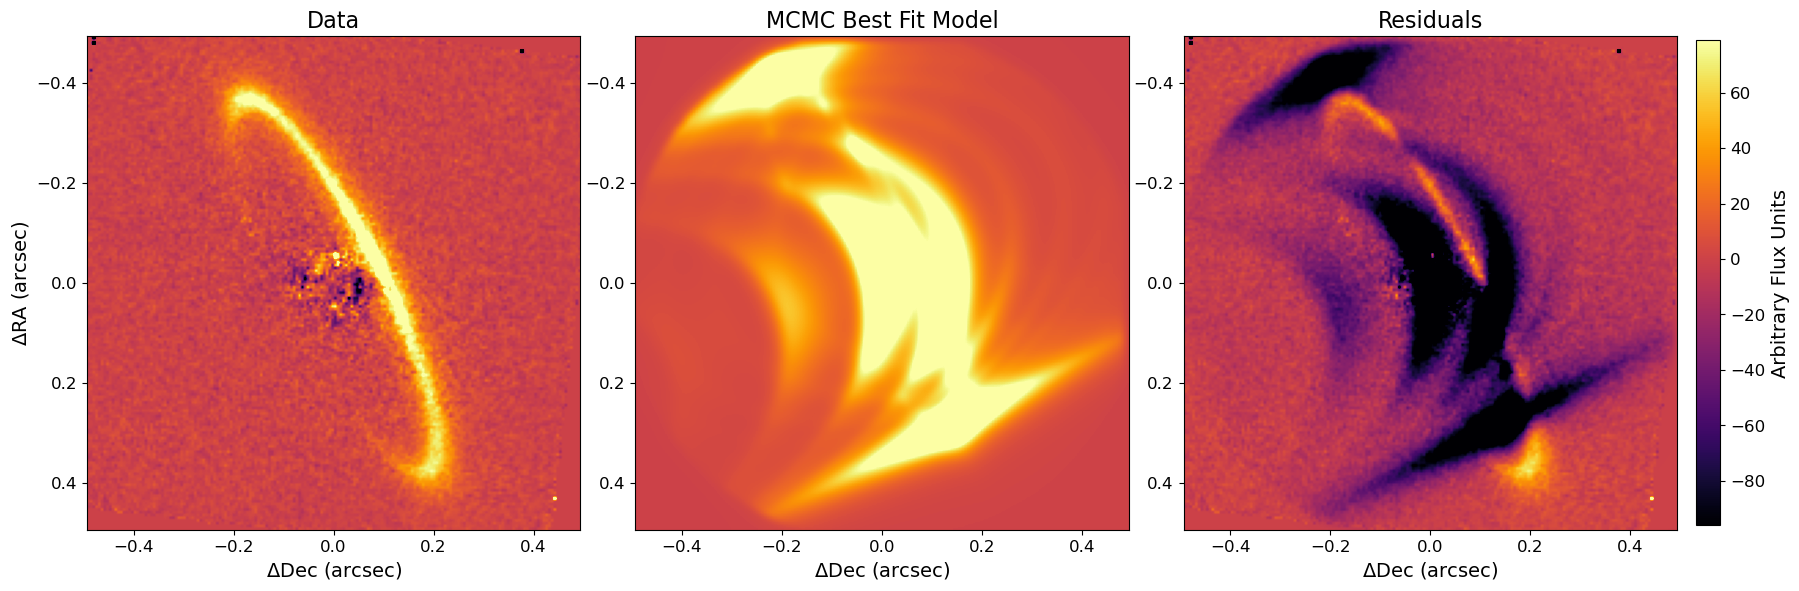

In [19]:
fig, axes = plt.subplots(1,3, figsize=(20,10))
mask = OptimizeUtils.get_mask(target_image)
vmin = np.nanpercentile(target_image[mask], 1)
vmax = np.nanpercentile(target_image[mask], 99)

xmax=70
extent = [-(xmax*14.1)/2000, (xmax*14.1)/2000, (xmax*14.1)/2000, -(xmax*14.1)/2000]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

im = axes[0].imshow(target_image, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[0].set_title("Data",fontsize=16)
axes[0].set_ylabel('$\Delta$RA (arcsec)',fontsize=14)
axes[0].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
#plt.colorbar(im, ax=axes[0], shrink=0.5)
im.set_clim(vmin, vmax)

im = axes[1].imshow(img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[1].set_title("MCMC Best Fit Model",fontsize=16)
#plt.colorbar(im, ax=axes[1], shrink=0.5)
im.set_clim(vmin, vmax)
axes[1].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)

im = axes[2].imshow(target_image-img, origin='lower', cmap='inferno',extent=extent,vmin=vmin,vmax=vmax)
axes[2].set_title("Residuals",fontsize=16)
im.set_clim(vmin, vmax)
axes[2].set_xlabel('$\Delta$Dec (arcsec)',fontsize=14)
plt.tight_layout()
cb = plt.colorbar(im, ax=axes, shrink=0.5,pad=0.01)
cb.set_label('Arbitrary Flux Units',fontsize=14)#,rotation=270)
cb.ax.tick_params(labelsize=12)
plt.savefig('../GPI_results/{}_MCMC_fit.png'.format(name))

In [22]:
samples = mc_model.sampler.get_chain()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/blewis/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3057991/822826470.py", line 1, in <module>
    mc_model.plot_chains(labels)
  File "/home/blewis/GRaTeR-JAX/optimization/mcmc_model.py", line 72, in plot_chains
    axes[i][j].plot(np.linspace(0, self.nwalkers, self.niter), self.sampler.get_chain()[:, :, cols_per_row*i+j].T)
  File "/home/blewis/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py", line 1779, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/blewis/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_base.py", line 296, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "/home/blewis/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_base.py"

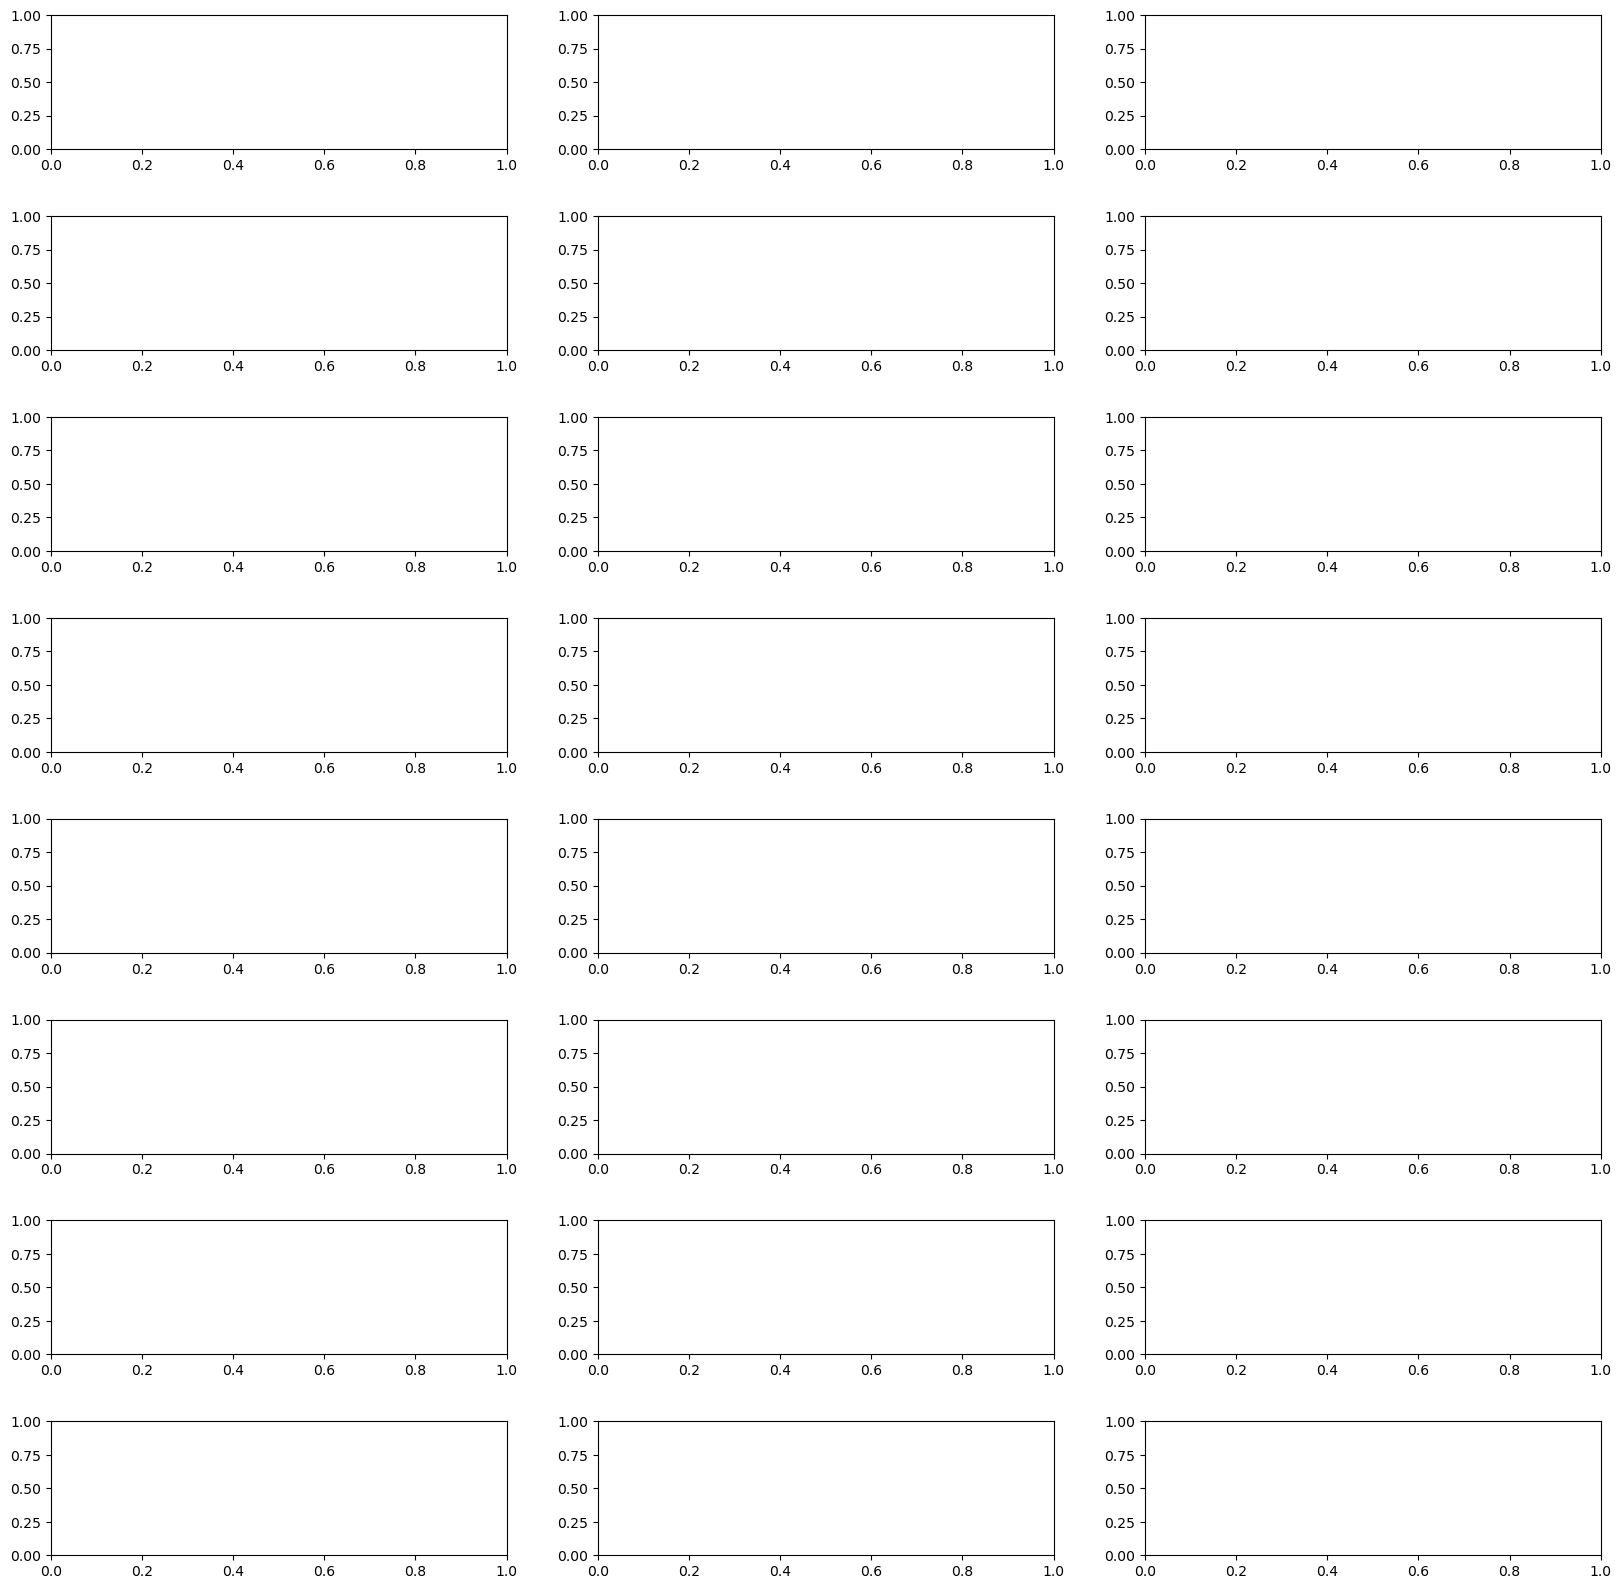

In [29]:
mc_model.plot_chains(labels)

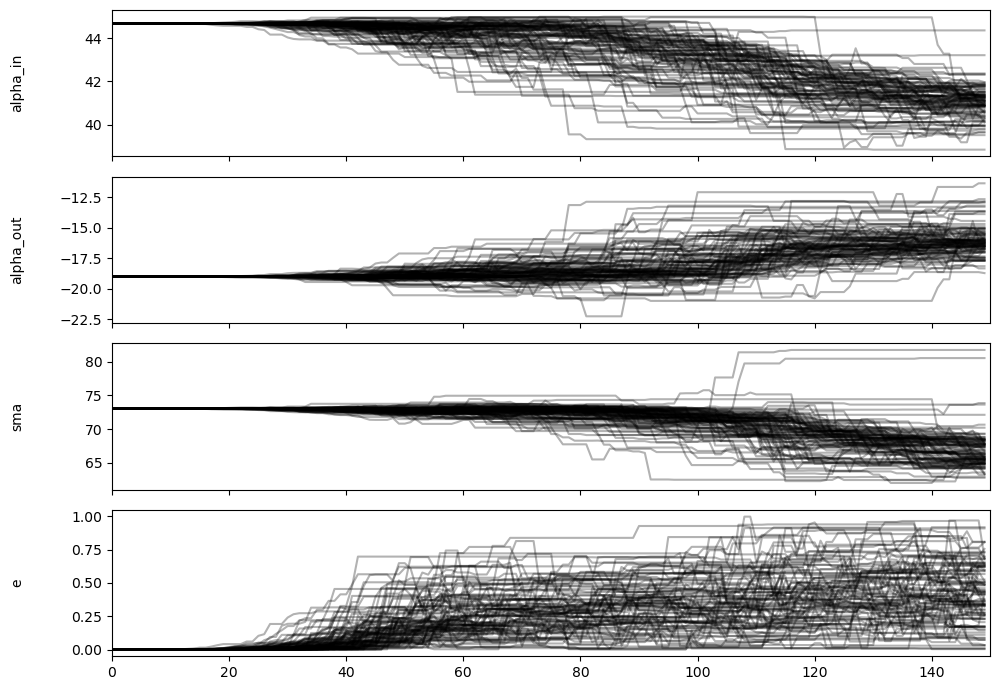

In [27]:
labels = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0', 'gamma', 'beta', 'omega', 'inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling']
for i in range(0, opt.spf_params['num_knots']):
    labels.append('k'+str(i+1))
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
plt.tight_layout()

[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too

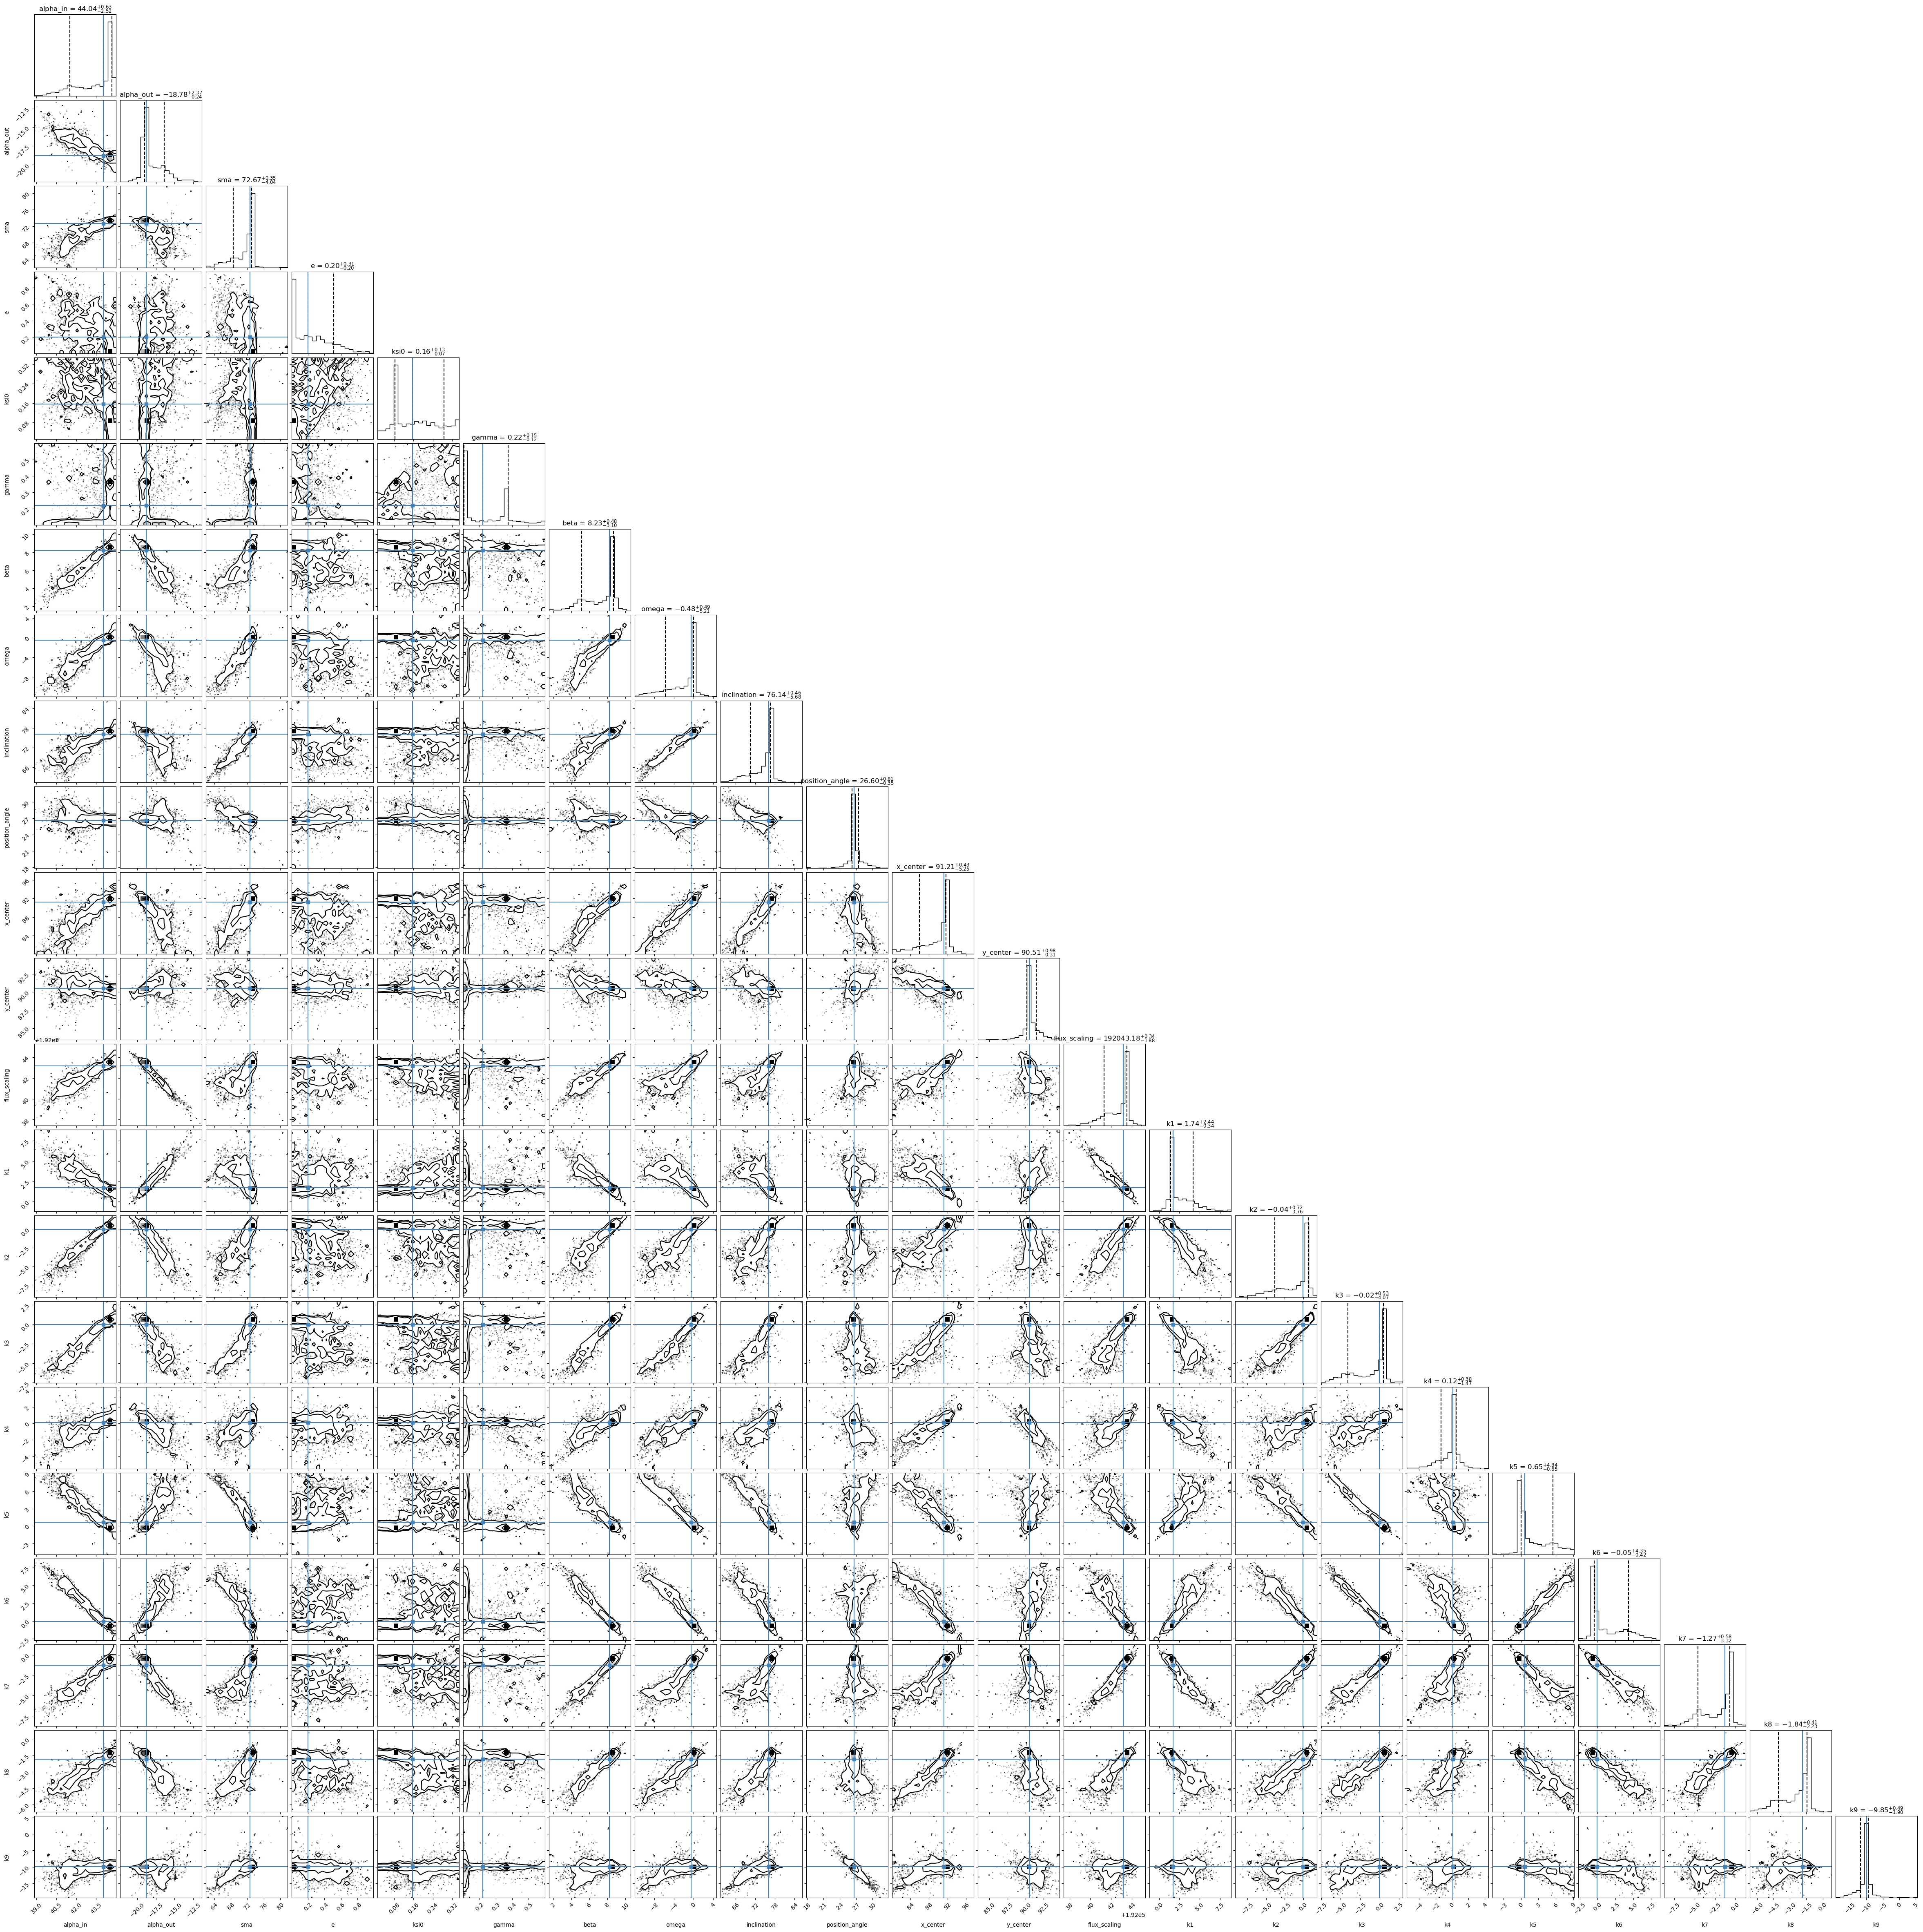

In [28]:
mc_model.show_corner_plot(labels, truths=mc_soln)

In [ ]:
hi = np.rad2deg(np.arccos(opt.spf_params['low_bound']))
lo = np.rad2deg(np.arccos(opt.spf_params['up_bound']))
print(hi,lo)

spf = spline_func.InterpolatedUnivariateSpline(np.linspace(lo,hi,9),opt.spf_params['knot_values'])

func = spf.__call__(np.linspace(0,180,100))

import matplotlib.pyplot as plt
plt.plot(np.linspace(0,180,100),func)
plt.scatter(np.linspace(lo,hi,9),opt.spf_params['knot_values'],color='orange')
plt.title('HR 4796A Pol SPF MCMC Fit (9 knots)')
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Arbitrary Units')
plt.savefig('../GPI_results/best_fits/hr4796a_pol_spf_MCMC.png',bbox_inches='tight')